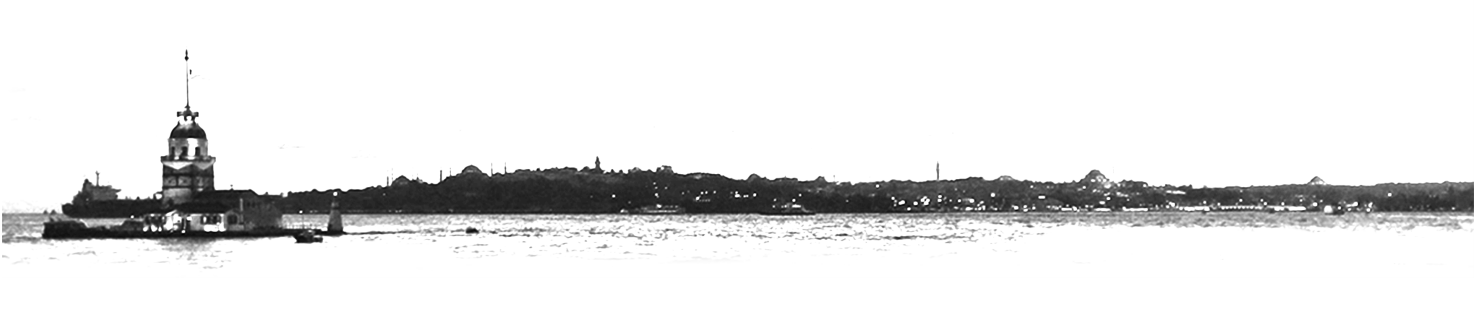


# Capstone Project - The Battle of the Neighborhoods 
Applied Data Science Capstone by IBM/Coursera

### A. Introduction 

#### A.1. A survey on the most popular venues around the main hospitals in Istanbul

Istanbul is the most populous city in Turkey and the country's economic, cultural and historic center with 15 million population and 2.813 people per square kilometer. The city is divided into 39 districts and most of the districts differ from each other with different characteristics [1]. 

According to the last data of TUIK, there are 33.052 doctors, 34.502 nurses, and 27.392 other health care workers currently working in Istanbul [2].

This analysis based on 22 university hospitals in Istanbul aims to be a guide for health care workers who are about to move to Istanbul and need information about the neighbourhood of hospital where they will work in.

#### A.2. Data description

Following data sources will be used to extract and generate the required information:

   - The dataset of health centers in Istanbul will be obtained from Istanbul Metropolitan Municipality [3]
    
   - The number of venues and their type and location in every hospital neighborhood will be obtained using Foursquare API [4]

### B. Data acquisition and cleaning

#### B.1. Data Sources

Let's start with getting the libraries which are needed for the project

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install geopy
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 
import json 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip install folium
import folium

!pip install -U yellowbrick
!pip install -U imbalanced-learn

print('Libraries imported.')

Requirement already up-to-date: yellowbrick in /Users/gonca/opt/anaconda3/lib/python3.8/site-packages (1.2)
Requirement already up-to-date: imbalanced-learn in /Users/gonca/opt/anaconda3/lib/python3.8/site-packages (0.7.0)
Libraries imported.


Let's obtain the dataset of health centers in Istanbul from Istanbul Metropolitan Municipality. To visualize the Turkish alphabet properly, 'windows-1254' encoding will be used.

In [2]:
url='https://data.ibb.gov.tr/dataset/bd3b9489-c7d5-4ff3-897c-8667f57c70bb/resource/f2154883-68e3-41dc-b2be-a6c2eb721c9e/download/salk-kurum-ve-kurulularna-ait-bilgiler.csv'
df=pd.read_csv(url, encoding='windows-1254')
df.head()

,ILCE_UAVT,ILCE_ADI,ADI,ALT_KATEGORI,ADRES,TELEFON,WEBSITESI,ACIL_SERVIS,YATAK,AMBULANS,MAHALLE,ENLEM,BOYLAM
0,1421.0,KADIKÖY,Marmara Veteriner Kliniği,Veteriner,Bahçeler Sk. No:3 FENERYOLU/KADIKÖY,0216 347 49 42,NaN,NaN,0.0,Yok,FENERYOLU,40.979645,29.050702
1,1327.0,FATİH,İstanbul Üniversitesi-Cerrahpaşa Tıp Fakültesi...,Poliklinik,İÜ Cerrahpaşa Tıp Fakültesi Yolu No: CERRAHPAŞ...,0212 414 23 59,http://istanbultip.istanbul.edu.tr,Var,60.0,NaN,CERRAHPAŞA,41.003546,28.942294
2,2015.0,TUZLA,Özel Saradent Ağız ve Diş Sağlığı Polikliniği,Özel Ağız Diş Sağlığı Merkezleri,İnönü Cad. ŞİFA/TUZLA,0216 423 23 63,www.saradent.com.tr,NaN,NaN,NaN,ŞİFA,40.826815,29.355745
3,1421.0,KADIKÖY,Atalay Veteriner Kliniği,Veteriner,Sinan Ercan Cad. No:6 19 MAYIS/KADIKÖY,0216 372 02 62,NaN,NaN,0.0,Yok,19 MAYIS,40.969398,29.085752
4,1421.0,KADIKÖY,Medipol Üniversitesi Hastanesi Kadıköy,Üniversite Hastanesi,Lambacı Sk. No:2/1 KOŞUYOLU/KADIKÖY,0216 544 66 66,www.medipol.com.tr,Var,72.0,Var,KOŞUYOLU,41.004663,29.034348


#### B.2. Data Cleaning and Feature Selection 

To clean the dataset:

   - The dataset includes all categories of health centers like veterinarians, dental practitioners or primary care physician. Firstly the results are filtered according to category and only university hospitals are selected for the project.
    
   - The unneeded columns are dropped and only hospital name, borough, neighbourhood, latitude and longitude data are kept.
   
   - The column names are converted to English since the original dataset is in Turkish. 

In [3]:
df_hospital=df[df['ALT_KATEGORI']=='Üniversite Hastanesi']
df_hospital=df_hospital.drop(['ILCE_UAVT','ALT_KATEGORI','TELEFON','ADRES','WEBSITESI','ACIL_SERVIS','YATAK','AMBULANS'], axis=1)
df_hospital=df_hospital.rename(columns={'ILCE_ADI': 'Borough', 'ADI': 'Hospital','MAHALLE': 'Neighbourhood','ENLEM': 'Latitude','BOYLAM': 'Longitude'})
df_hospital=df_hospital.reset_index(drop=True)
df_hospital.head()

,Borough,Hospital,Neighbourhood,Latitude,Longitude
0,KADIKÖY,Medipol Üniversitesi Hastanesi Kadıköy,KOŞUYOLU,41.004663,29.034348
1,BEYOĞLU,İBÜ Avrupa Florence Nightingale Hastanesi Araş...,BEDRETTİN,41.028978,28.970739
2,BAHÇELİEVLER,Aydın Üniversitesi Ağız ve Diş Sağlığı Merkezi,BAHÇELİEVLER,41.001714,28.870994
3,KÜÇÜKÇEKMECE,Biruni Üniversitesi Tıp Fakültesi Hastanesi,BEŞYOL,40.988752,28.796307
4,BAĞCILAR,Medipol Mega Hastaneler Kompleksi,GÖZTEPE,41.058331,28.842234


Let's check the shape of the dataframe. There are 22 university hospitals in Istanbul.

In [4]:
df_hospital.shape

(22, 5)

Let's see the location of the hospitals in map.

In [5]:
# create map
map_hospitals = folium.Map(location=[df_hospital['Latitude'][0],df_hospital['Longitude'][0]], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, hos in zip(df_hospital['Latitude'], df_hospital['Longitude'], df_hospital['Hospital']):
    label = folium.Popup(str(hos), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_hospitals)
       
map_hospitals

Now that we have location of hospitals, let's use Foursquare API to get info on venues in each neighborhood.

In [6]:
CLIENT_ID = 'FKCGWGBAY4RGGYB02SCBRLOSDN4CWUANFY5ODSQ3YLK1ZCA5' # Foursquare ID
CLIENT_SECRET = 'DAPEQAYLFNGU03NXGA45LQN1M353TXMZ01KUZRE2HGD2KMFI' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's define a function  and use it to extract the category of the venues (max:100) around hospital locations in a circle with 500m radius.

In [7]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hospital', 
                  'Hospital Latitude', 
                  'Hospital Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [8]:
hospital_venues = getNearbyVenues(names=df_hospital['Hospital'],
                                   latitudes=df_hospital['Latitude'],
                                   longitudes=df_hospital['Longitude'])

hospital_venues.head()

Medipol Üniversitesi Hastanesi Kadıköy
İBÜ Avrupa Florence Nightingale Hastanesi Araştırma ve Uygulama Merkezi Bedii Gorbon Kanser Merkezi
Aydın Üniversitesi Ağız ve Diş Sağlığı Merkezi
Biruni Üniversitesi Tıp Fakültesi Hastanesi
Medipol Mega Hastaneler Kompleksi
Medipol Üniversitesi Hastanesi Esenler 
İstanbul Aydın Üniversitesi Diş Hekimliği Fakültesi Hastanesi
Bezmialem Vakıf Üniversitesi Dragos Hastanesi
Yeditepe Üniversitesi Hastanesi
Maltepe Üniversitesi Tıp Fakültesi Hastanesi
Koç Üniversitesi Hastanesi
Bezmialem Vakıf Üniversitesi Tıp Fakültesi Hastanesi
Medipol Üniversitesi Hastanesi Fındıkzade
Yeditepe Üniversitesi Hastanesi Diş Hekimliği Fakültesi ve Diş Hastanesi
İstanbul Üniversitesi Tıp Fakültesi Hastanesi
İstanbul Üniversitesi-Cerrahpaşa Tıp Fakültesi Hastanesi
Başkent Üniversitesi İstanbul Sağlık Uygulama ve Araştırma Hastanesi
Yeditepe Üniversitesi İhtisas Hastanesi
İ.A.Ü. VMI MEDİCAL PARK HASTANESİ FLORYA
Sefaköy Medipol Üniversitesi Hastanesi
Avrupa Florence Nıghtıng

,Hospital,Hospital Latitude,Hospital Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Özgür Saç & Sanat,41.005757,29.036199,Salon / Barbershop
1,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Kuaför İmaj,41.005314,29.032333,Salon / Barbershop
2,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Sarıyer Börekçisi,41.005484,29.032646,Breakfast Spot
3,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,Ezineli Gurme,41.005690,29.036104,Breakfast Spot
4,Medipol Üniversitesi Hastanesi Kadıköy,41.004663,29.034348,"Kipos Balık ""Ayvalık Cunda Mutfağı""",41.006951,29.033147,Fish Taverna


Now, we have a dataframe including the hospitals, hospital location, venue names, categories and locations. There are 1450 venues in total which are extracted from Foursquare API.

In [9]:
hospital_venues.shape

(1450, 7)

### C.Methodology

In this project I direct my efforts on creating a guide for health care workers who are about to move to Istanbul and need information about their working environment.I aim to define the most popular venues around main hospitals in Istanbul and cluster them.

In first step I have collected the required data: name and location of the hospitals, category and location of the venues within 500m from the defined hospitals.

Now, we have some common venue categories around defined hospitals. Second step in our analysis will be clustering the data. 

I decided to use K-means algorithm to cluster the hospitals, which is one of the most common clustering method of unsupervised learning. K-means is a partition-based clustering which is relatively efficient on medium and large sized data sets. Despite it is considered the one of the simplest models, k-means is especially useful for quick insights from unlabeled data. 

It produces sphere-like clusters because the clusters are shaped around the centroids and, its drawback is that we should pre-specify the number of clusters. To define this number, I will analyze the K-Means with elbow method. 

Determining the number of clusters in a data set is a frequent problem in data clustering. The correct choice of K is very dependent on the shape and scale of the distribution of points in a dataset. Elbow method runs the clustering across the different values of K. But the problem is that with increasing the number of clusters, the distance of centroids to data points will always reduce. This means increasing K will always decrease the error. So, the value of the metric as a function of K is plotted and the elbow point is determined where the rate of decrease sharply shifts. It is the right K for clustering. This method is called the elbow method [5].



#### C.1. Analyse

Before starting to cluster, let's convert the dataframe by using get_dummies method of pandas. Next, let's group rows by 'Hospital' and by taking the mean of the frequency of occurrence of each category.

In [10]:
# one hot encoding
hospital_onehot = pd.get_dummies(hospital_venues[['Venue Category']], prefix="", prefix_sep="")
hospital_onehot['Hospital']=hospital_venues['Hospital']
fixed_columns = [hospital_onehot.columns[-1]] + list(hospital_onehot.columns[:-1])
hospital_onehot = hospital_onehot[fixed_columns]
hospital_onehot.head()

,Hospital,Advertising Agency,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Bath House,Bay,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Borek Place,Boutique,Brasserie,Breakfast Spot,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Campground,Candy Store,Cemetery,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Factory,Farmers Market,Fast Food Restaurant,Fish Market,Fish Taverna,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Pool,Hunting Supply,Ice Cream Shop,Italian Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Lingerie Store,Lounge,Manti Place,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Office,Optical Shop,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilavcı,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Record Shop,Recording Studio,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shopping Mall,Shrine,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Tailor Shop,Tantuni Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Veterinarian,Water Park,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Medipol Üniversitesi Hastanesi Kadıköy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Medipol Üniversitesi Hastanesi Kadıköy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Medipol Üniversitesi Hastanesi Kadıköy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [11]:
hospital_grouped = hospital_onehot.groupby('Hospital').mean().reset_index()
hospital_grouped.head()

,Hospital,Advertising Agency,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Bath House,Bay,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Borek Place,Boutique,Brasserie,Breakfast Spot,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Campground,Candy Store,Cemetery,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Factory,Farmers Market,Fast Food Restaurant,Fish Market,Fish Taverna,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Pool,Hunting Supply,Ice Cream Shop,Italian Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Lingerie Store,Lounge,Manti Place,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Office,Optical Shop,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilavcı,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Record Shop,Recording Studio,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shopping Mall,Shrine,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Tailor Shop,Tantuni Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Veterinarian,Water Park,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Avrupa Florence Nıghtıngale Hatanesi Araştırma...,0.0125,0.0,0.0,0.012500,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.025000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012500,0.0,0.0,0.000000,0.000000,0.012500,0.0,0.025000,0.0,0.00000,0.0,0.0,0.0,0.075000,0.00000,0.0,0.0,0.0,0.0,0.075000,0.0,0.037500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0125,0.000000,0.012500,0.0,0.0125,0.012500,0.000000,0.0,0.050000,0.012500,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.012500,0.0,0.0,0.0,0.0,0.0,0.0125,0.0,0.00000,0.000000,0.0,0.025000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.025000,0.050000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.025000,0.0125,0.0,0.000000,0.0125,0.000000,0.0,0.0,0.01250,0.025000,0.0,0.000000,0.0125,0.0125,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0125,0.000000,0.00000,0.0125,0.000000,0.0,0.0,0.0125,0.0,0.0,0.0,0.000000,0.000000,0.0125,0.0,0.000000,0.000000,0.0125,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0125,0.075000,0.0,0.0125,0.0,0.0,0.0,0.00000,0.012500,0.0,0.000000,0.

To show the number of venues around each hospital, let's define a new dataframe and create a bar chart.

In [12]:
hospital_bar = hospital_onehot.groupby('Hospital').sum().reset_index()
hospital_bar['Venue number'] = hospital_bar.sum(axis=1)
hospital_bar = hospital_bar.drop(hospital_bar.columns.difference(['Venue number','Hospital']), axis=1) 
hospital_bar = hospital_bar.set_index('Hospital')
hospital_bar = hospital_bar.sort_values(by=['Venue number'])
hospital_bar.head()

,Venue number
Hospital,
Medipol Üniversitesi Hastanesi Esenler,24
Sefaköy Medipol Üniversitesi Hastanesi,28
Medipol Mega Hastaneler Kompleksi,31
Bezmialem Vakıf Üniversitesi Dragos Hastanesi,32
Bezmialem Vakıf Üniversitesi Tıp Fakültesi Hastanesi,38


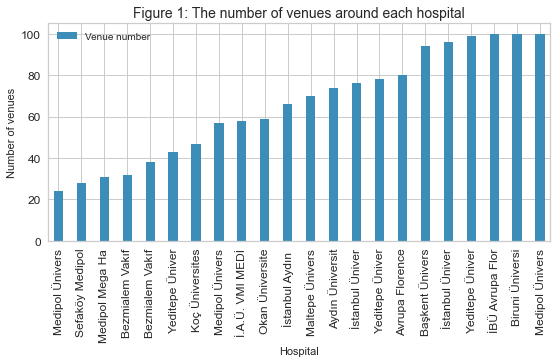

In [34]:
ax=hospital_bar.plot(kind='bar', figsize=(9, 4), facecolor = '#3c8eb8', fontsize= 12, width = 0.4,)
plt.title('Figure 1: The number of venues around each hospital', fontsize= 14)
plt.ylabel('Number of venues')
ax.set_xticklabels(item.get_text()[:15] for item in ax.get_xticklabels())
plt.show()


#### C.2. Clustering

To understand the data better before clustering, let's define a function and create a dataframe showing the most common venues around each hospital.

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hospital']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hospital_venues_sorted = pd.DataFrame(columns=columns)
hospital_venues_sorted['Hospital'] = hospital_grouped['Hospital']

for ind in np.arange(hospital_grouped.shape[0]):
    hospital_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hospital_grouped.iloc[ind, :], num_top_venues)

hospital_venues_sorted.head()

,Hospital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Avrupa Florence Nıghtıngale Hatanesi Araştırma...,Café,Clothing Store,Restaurant,Gym / Fitness Center,Dessert Shop,Sporting Goods Shop,Coffee Shop,Theater,Furniture / Home Store,Burger Joint
1,Aydın Üniversitesi Ağız ve Diş Sağlığı Merkezi,Café,Bakery,Restaurant,Turkish Restaurant,Trail,Dessert Shop,Seafood Restaurant,Hookah Bar,Gym,Breakfast Spot
2,Başkent Üniversitesi İstanbul Sağlık Uygulama ...,Café,Restaurant,Dessert Shop,Coffee Shop,Dance Studio,Pastry Shop,Gym / Fitness Center,Baby Store,Hotel,Sushi Restaurant
3,Bezmialem Vakıf Üniversitesi Dragos Hastanesi,Pool,Café,Turkish Restaurant,Nightclub,Hotel,Steakhouse,Athletics & Sports,Dry Cleaner,Food Truck,Kebab Restaurant
4,Bezmialem Vakıf Üniversitesi Tıp Fakültesi Has...,Café,Turkish Restaurant,Restaurant,Pub,Mosque,Comfort Food Restaurant,Garden,Diner,Shrine,Middle Eastern Restaurant


Now, it is time to create a dataframe to use in clustering.

In [16]:
hospital_grouped_clustering = hospital_grouped.drop('Hospital', 1)

  
 
Before fit the data in KMeans clustering, let's use Elbow method to define the optimal cluster number and the score.

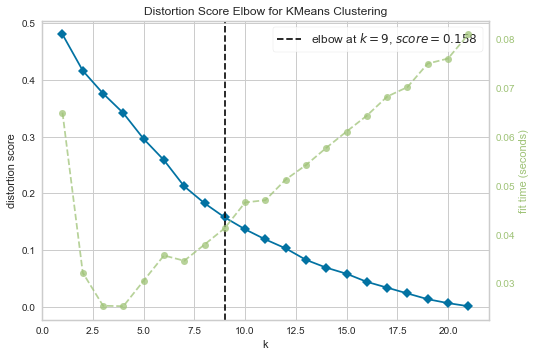

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,22))

visualizer.fit(hospital_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

 
 
According to the results, elbow method ensured me the 9 degree for optimum k of the K-Means.

In [18]:
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hospital_grouped_clustering)

# add clustering labels
hospital_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge dataframes to add latitude/longitude for each hospital
hospital_merged = df_hospital
hospital_merged = hospital_merged.join(hospital_venues_sorted.set_index('Hospital'), on='Hospital')

hospital_merged.head() 

,Borough,Hospital,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,KADIKÖY,Medipol Üniversitesi Hastanesi Kadıköy,KOŞUYOLU,41.004663,29.034348,0,Café,Coffee Shop,Park,Turkish Restaurant,Grocery Store,Breakfast Spot,Health & Beauty Service,Dance Studio,Gym Pool,Pool
1,BEYOĞLU,İBÜ Avrupa Florence Nightingale Hastanesi Araş...,BEDRETTİN,41.028978,28.970739,1,Café,Hotel,Restaurant,Coffee Shop,Cocktail Bar,Bar,Turkish Restaurant,Meyhane,Italian Restaurant,Concert Hall
2,BAHÇELİEVLER,Aydın Üniversitesi Ağız ve Diş Sağlığı Merkezi,BAHÇELİEVLER,41.001714,28.870994,8,Café,Bakery,Restaurant,Turkish Restaurant,Trail,Dessert Shop,Seafood Restaurant,Hookah Bar,Gym,Breakfast Spot
3,KÜÇÜKÇEKMECE,Biruni Üniversitesi Tıp Fakültesi Hastanesi,BEŞYOL,40.988752,28.796307,1,Café,Coffee Shop,Dessert Shop,Hotel,Restaurant,Breakfast Spot,Turkish Restaurant,Furniture / Home Store,Pizza Place,Doner Restaurant
4,BAĞCILAR,Medipol Mega Hastaneler Kompleksi,GÖZTEPE,41.058331,28.842234,7,Café,Garden,Restaurant,Kebab Restaurant,Convenience Store,Kofte Place,Soccer Stadium,Burger Joint,Food Court,Electronics Store




At this point, let's create a bar chart showing the number of 1st Most Common Venues in each cluster. It would be helpful to use together with the table showing the most common venues around each hospital to find proper label names for each cluster.

In [19]:
barchart2 = hospital_onehot.groupby('Hospital').sum().reset_index()
barchart2=pd.merge(barchart2,hospital_merged[['Hospital', 'Cluster Labels']],on='Hospital')
fixed_columns = [barchart2.columns[-1]] + list(barchart2.columns[:-1])
barchart2 = barchart2[fixed_columns]
barchart2['Cluster Labels'] = 'Cluster No:' + barchart2['Cluster Labels'].astype(str)
barchart2 = barchart2.drop(['Hospital'], axis=1)

barchart2=barchart2.groupby(['Cluster Labels']).sum()

columns=list(set(hospital_merged['1st Most Common Venue']))
barchart2=barchart2[columns]
barchart2

,Café,Pool,Clothing Store,Turkish Restaurant,Arcade
Cluster Labels,,,,,
Cluster No:0,15,2,3,8,0
Cluster No:1,49,0,0,12,0
Cluster No:2,21,1,2,21,0
Cluster No:3,42,1,0,20,1
Cluster No:4,3,0,0,2,3
Cluster No:5,5,0,0,0,0
Cluster No:6,3,3,0,3,0
Cluster No:7,7,0,0,0,1
Cluster No:8,53,1,14,20,2


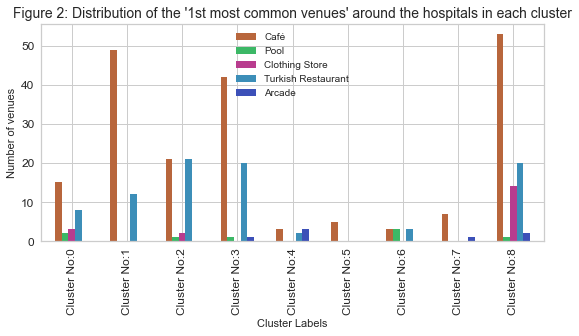

In [33]:
mycolors = ['#b8663c', '#3cb866', '#b83c8e', '#3c8eb8', '#3c50b8']
barchart2.plot(kind='bar', figsize=(9,4), fontsize=12, color=mycolors, width=0.6)
plt.ylabel('Number of venues')
plt.title("Figure 2: Distribution of the '1st most common venues' around the hospitals in each cluster", fontsize= 14)

plt.show()

Finally, lets create a master table to combine all relevant information and use this table to create a map showing hospital locations, names, cluster numbers and defined cluster names.

In [21]:
master_table=hospital_merged
master_table['Cluster Names'] = master_table['Cluster Labels']
master_table['Cluster Names'] = master_table['Cluster Names'].astype(str).map({'0': 'Cafe & Clothing Store', '1': 'Cafe & Hotel', '2': 'Cafe & Restaurant', '3': 'Cafe & Bakery', '4': 'Arcade & Cafe', '5': 'Cafe & Theather', '6': 'Pool & Cafe', '7': 'Cafe & Garden', '8': 'Cafe & Restaurant & Clothing Store'})
cols=['Hospital','Borough','Neighbourhood','Cluster Labels','Cluster Names','1st Most Common Venue','2nd Most Common Venue',
'3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue',
'9th Most Common Venue','10th Most Common Venue','Longitude', 'Latitude']
master_table = master_table[cols]
master_table = master_table.sort_values(by=['Cluster Labels'])
master_table = master_table.reset_index()
master_table = master_table.drop(['index'],axis=1)
master_table.head()

,Hospital,Borough,Neighbourhood,Cluster Labels,Cluster Names,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Longitude,Latitude
0,Medipol Üniversitesi Hastanesi Kadıköy,KADIKÖY,KOŞUYOLU,0,Cafe & Clothing Store,Café,Coffee Shop,Park,Turkish Restaurant,Grocery Store,Breakfast Spot,Health & Beauty Service,Dance Studio,Gym Pool,Pool,29.034348,41.004663
1,Yeditepe Üniversitesi İhtisas Hastanesi,KADIKÖY,KOŞUYOLU,0,Cafe & Clothing Store,Clothing Store,Coffee Shop,Café,Gym Pool,Breakfast Spot,Gym,Turkish Restaurant,Tunnel,Salon / Barbershop,Restaurant,29.031553,41.004059
2,Yeditepe Üniversitesi Hastanesi Diş Hekimliği ...,KADIKÖY,CADDEBOSTAN,0,Cafe & Clothing Store,Café,Cosmetics Shop,Yoga Studio,Gym / Fitness Center,Coffee Shop,Dessert Shop,Italian Restaurant,Burger Joint,Seafood Restaurant,Pizza Place,29.057845,40.972220
3,İBÜ Avrupa Florence Nightingale Hastanesi Araş...,BEYOĞLU,BEDRETTİN,1,Cafe & Hotel,Café,Hotel,Restaurant,Coffee Shop,Cocktail Bar,Bar,Turkish Restaurant,Meyhane,Italian Restaurant,Concert Hall,28.970739,41.028978
4,İ.A.Ü. VMI MEDİCAL PARK HASTANESİ FLORYA,KÜÇÜKÇEKMECE,BEŞYOL,1,Cafe & Hotel,Café,Hotel,Breakfast Spot,Coffee Shop,Restaurant,Furniture / Home Store,Lounge,Kebab Restaurant,Dessert Shop,Turkish Restaurant,28.797429,40.990210


In [22]:
# create map
map_clusters = folium.Map(location=[master_table['Latitude'][0],master_table['Longitude'][0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, hos, cluster, cat in zip(master_table['Latitude'], master_table['Longitude'], master_table['Hospital'], master_table['Cluster Labels'], master_table['Cluster Names']):
    label = folium.Popup(str(hos) + ' - Cluster:' + str(cluster) + ' - Category:' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### D. Results and Discussion

Istanbul is a big city and economic, cultural and historic center of the country with a high population density in a narrow area. The city is divided into 39 districts and most of the districts differ from each other with different characteristics. Thus, it is always challenging for the new residents to understand the dynamics of the city. 

This analysis aims to be a guide for health care workers who are about to move to Istanbul and need information about the neighbourhood of hospital where they will work in. There are more than 95 thousands of health care workers, currently working in Istanbul.

This analysis based on 22 university hospitals in Istanbul. The Kmeans algorithm was preferred as part of this clustering study. According to the results of Elbow method, the optimum k value was set to 9. 

I created  bar charts showing the number of venues around each hospital and the distribution of the '1st most common venues' around the hospitals in each cluster.

I ended the study by visualysing the data and clustering information of the hospitals on the Istanbul map including hospital locations, names, cluster numbers and defined cluster names.

### E. Conclusion

In this study, I analysed the venues around the main hospitals in Istanbul/Turkey to guide new residents of Istanbul as a health care worker. For more detailed and accurate guidance, the data set can be expanded so other hospitals can also be drilled, and different approaches can be tried in clustering and classification.

### F. References

[1] https://en.wikipedia.org/wiki/Istanbul

[2] https://data.tuik.gov.tr/Bulten/DownloadIstatistikselTablo?p=1sDY/9oQZO8DamcSJ9zgtnOrS10JgqV1stehK2Rz9SbQD33xL9rhoK4BN8742etP

[3] https://data.ibb.gov.tr/dataset/istanbul-saglik-kurum-ve-kuruluslari-verisi

[4] https://developer.foursquare.com

[5] https://www.coursera.org/learn/machine-learning-with-python/lecture/rLcgP/more-on-k-means